# Snowpylot demo for Western Snow Conference 2025
Demonstrating the functionality of the snowpylot library using snowpits from the 2020-2024 water years


### Set Up an Data Import

#### Import Libraries

In [1]:
# Import libraries
import os
import textwrap

import folium
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from folium.plugins import HeatMap

from snowpylot.caaml_parser import caaml_parser


#### parse_pits function: Parses all pits in a specified folder

In [2]:
def parse_pits(folder_path):
    """
    Function to parse CAAML files in the specified folder
    """

    files = [
        f for f in os.listdir(folder_path) if f.endswith(".xml")
    ]  # List of all .xml files in the folder

    pits_list = []

    for file in files:  # iterate through each file in the folder
        file_path = folder_path + "/" + file  # create the file path
        pit = caaml_parser(file_path)  # parse the file
        pits_list.append(pit)

    return pits_list

#### Specify folders for 2020-2024 Water Years and parse files

In [3]:
# Define folders and parse pits

pits_19_20 = parse_pits("snowpits/by_season/2019-2020")
pits_20_21 = parse_pits("snowpits/by_season/2020-2021")
pits_21_22 = parse_pits("snowpits/by_season/2021-2022")
pits_22_23 = parse_pits("snowpits/by_season/2022-2023")
pits_23_24 = parse_pits("snowpits/by_season/2023-2024")

all_pits = (
    pits_19_20 + pits_20_21 + pits_21_22 + pits_22_23 + pits_23_24
)  # list of all pits

### Core Info

#### Create DataFrame of Core Info for all Pits

In [4]:
core_info_list = []

for pit in all_pits:
    core_info_dict = {
        # metadata
        "PitID": pit.core_info.pit_id,
        "Date": pit.core_info.date,
        # User
        "SnowPilot Username": pit.core_info.user.username,
        "Professional": pit.core_info.user.professional,
        "Operation Name": pit.core_info.user.operation_name,
        # Location
        "Latitude": pit.core_info.location.latitude,
        "Longitude": pit.core_info.location.longitude,
        "Elevation": pit.core_info.location.elevation,
        "Aspect": pit.core_info.location.aspect,
        "Slope Angle": pit.core_info.location.slope_angle,
        "Country": pit.core_info.location.country,
        "Region": pit.core_info.location.region,
        "Pit Near Avalanche": pit.core_info.location.pit_near_avalanche,
        "Pit Near Avalanche Location": pit.core_info.location.pit_near_avalanche_location
    }
    core_info_list.append(core_info_dict)

core_info_df = pd.DataFrame(core_info_list)

In [5]:
# Update country and region for pits with "UT" as country
mask = core_info_df["Country"] == "UT"
core_info_df.loc[mask, "Country"] = "US"
core_info_df.loc[mask, "Region"] = "UT"

#### Create Summary Tables of Core Info

In [6]:
# Create a summary table of core_info_df
core_info_summary = {
    "Total Pits": len(core_info_df),  # Total quantity of PitID
    "Unique Users": core_info_df["SnowPilot Username"].nunique(),  # Unique Usernames
    "Professional Pits": core_info_df[
        "Professional"
    ].sum(),  # Count of Professional = True
    "Non-professional Pits": (
        ~core_info_df["Professional"]
    ).sum(),  # Count of Professional = False
    "Operation with the Most Pits": core_info_df["Operation Name"]
    .value_counts()
    .index[0],
    "Number of Pits Submitted by the CIAC": core_info_df["Operation Name"]
    .value_counts()
    .iloc[0],
}

print("Summary of Pit MetaData:")
for key, value in core_info_summary.items():
    print(key + ":" + str(value))

location_info_summary = {
    "Unique Countries": core_info_df["Country"].nunique(),  # Unique Countries
    "Pits Near an Avalanche": core_info_df[
        "Pit Near Avalanche"
    ].sum(),  # Count of Pit Near Avalanche = True
    "Pits on Avalanche Crown": core_info_df[
        core_info_df["Pit Near Avalanche Location"] == "crown"
    ].shape[0],
    "Pits on Avalanche Flank": core_info_df[
        core_info_df["Pit Near Avalanche Location"] == "flank"
    ].shape[0],
}

print("\nSummary of Location Info:")
for key, value in location_info_summary.items():
    print(key + ":" + str(value))

Summary of Pit MetaData:
Total Pits:31170
Unique Users:3854
Professional Pits:19891
Non-professional Pits:11279
Operation with the Most Pits:Colorado Avalanche Information Center
Number of Pits Submitted by the CIAC:1496

Summary of Location Info:
Unique Countries:30
Pits Near an Avalanche:945
Pits on Avalanche Crown:480
Pits on Avalanche Flank:240


#### Create Pie Chart of Qty Of Snow Pits by Country

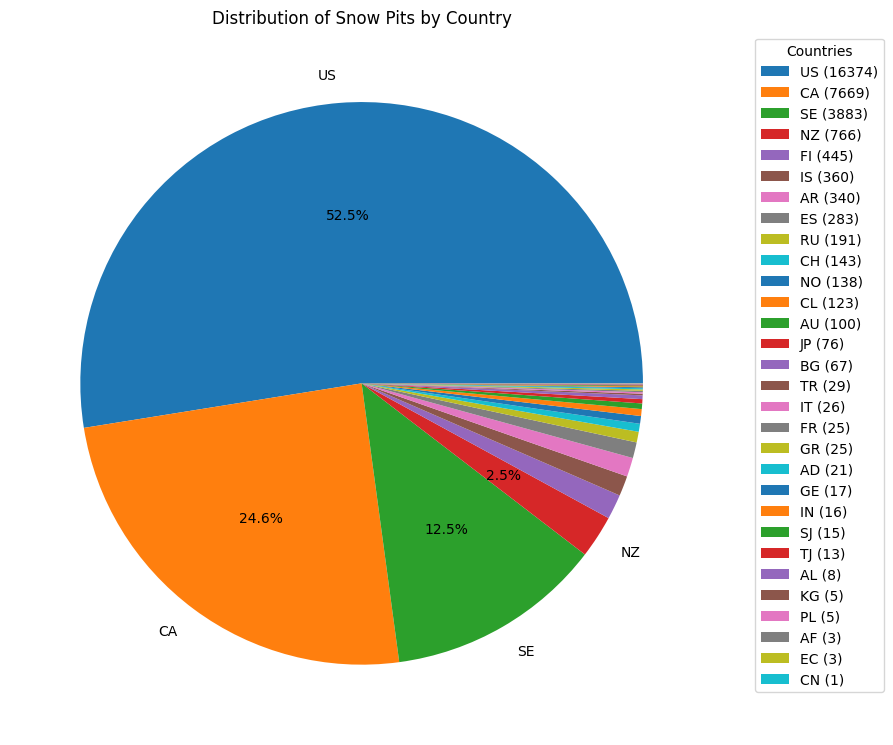

In [7]:
# Create a pie chart of snow pits by country
plt.figure(figsize=(12, 8))

# Get the count of pits by country
country_counts = core_info_df["Country"].value_counts()

# Calculate percentages
total_pits = country_counts.sum()
percentages = (country_counts / total_pits) * 100

# Create lists for labels and values, only including labels for >2%
labels = []
values = []
for country, count in country_counts.items():
    percentage = (count / total_pits) * 100
    if percentage > 2:
        labels.append(country)
    else:
        labels.append("")  # Empty label for small slices
    values.append(count)


# Create a function to format the percentage labels
def make_autopct(values):
    def my_autopct(pct):
        # Only show percentage if it's greater than 2%
        if pct > 2:
            return f"{pct:.1f}%"
        return ""

    return my_autopct


# Create the pie chart
plt.pie(values, labels=labels, autopct=make_autopct(values))

# Add a title
plt.title("Distribution of Snow Pits by Country")

# Add a legend with country codes and counts (including all countries)
plt.legend(
    [
        f"{country} ({count})"
        for country, count in zip(country_counts.index, country_counts.values)
    ],
    title="Countries",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

#### Create Heatmap of Snow Pit Locations in the US

In [8]:
# Filter for US locations only and remove any rows with missing coordinates
us_pits = core_info_df[
    (core_info_df["Country"] == "US")
    & (core_info_df["Latitude"].notna())
    & (core_info_df["Longitude"].notna())
].copy()

# Create a list of locations for the heatmap
locations = us_pits[["Latitude", "Longitude"]].values.tolist()

# Create a base map centered on the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add the heatmap layer
HeatMap(locations).add_to(m)

# Display the map
m

### Snow Profile

#### Create Dataframe Of SnowProfile Info for All Pits

In [9]:
snow_profile_list = []

for pit in all_pits:
    num_primary_grain_form = 0  # initialize
    num_primary_grain_size = 0  # initialize
    for layer in pit.snow_profile.layers:  # iterate through each layer in the pit
        if layer.grain_form_primary is not None:  # if the layer has a primary grain form
            num_primary_grain_form += 1  # increment the number of primary grain forms
            if (
                layer.grain_form_primary.grain_size_avg is not None
            ):  # if the layer has a primary grain size
                num_primary_grain_size += 1  # increment the number of primary grain sizes

    snow_profile_dict = {
        "PitID": pit.core_info.pit_id,
        "Measurement Direction": pit.snow_profile.measurement_direction,
        "Profile Depth": pit.snow_profile.profile_depth,
        "HS": pit.snow_profile.hs,
        # Surface Conditions
        "Foot Penetration": pit.snow_profile.surf_cond.penetration_foot,
        "Ski Penetration": pit.snow_profile.surf_cond.penetration_ski,
        # Layers
        "Num Layers": len(pit.snow_profile.layers),
        "num Layers wPrimary Grain Form": num_primary_grain_form,
        "num Layers wPrimary Grain Size": num_primary_grain_size,
        # Temp Profile
        "Temp Profile": True if pit.snow_profile.temp_profile is not None else False,
        "Num Temp Obs": len(pit.snow_profile.temp_profile)
        if pit.snow_profile.temp_profile is not None
        else 0,
        # Density Profile
        "Density Profile": True
        if pit.snow_profile.density_profile is not None
        else False,
        "Num Density Obs": len(pit.snow_profile.density_profile)
        if pit.snow_profile.density_profile is not None
        else 0,
    }
    snow_profile_list.append(snow_profile_dict)

snow_profile_df = pd.DataFrame(snow_profile_list)

#### Create Summary Tables of Snow Profile Info

In [10]:
snow_profile_summary = {
    "Total Pits": len(snow_profile_df),
    "Number of Layers": snow_profile_df["Num Layers"].sum(),
    "Number of Layers with Primary Grain Form": snow_profile_df[
        "num Layers wPrimary Grain Form"
    ].sum(),
    "Number of Layers with Primary Grain Size": snow_profile_df[
        "num Layers wPrimary Grain Size"
    ].sum(),
    "Number of Pits with Temperature Profile": snow_profile_df["Temp Profile"].sum(),
    "Number of Temperature Observations": snow_profile_df["Num Temp Obs"].sum(),
    "Number of Pits with Density Profile": snow_profile_df["Density Profile"].sum(),
    "Number of Density Observations": snow_profile_df["Num Density Obs"].sum(),
    "Number of Pits with Foot Penetration": snow_profile_df["Foot Penetration"]
    .notna()
    .sum(),  # Changed to count non-null values
    "Number of Pits with Ski Penetration": snow_profile_df["Ski Penetration"]
    .notna()
    .sum(),  # Changed to count non-null values
}

print("Summary of Snow Profile Info:")
for key, value in snow_profile_summary.items():
    print(key + ":" + str(value))

Summary of Snow Profile Info:
Total Pits:31170
Number of Layers:232718
Number of Layers with Primary Grain Form:190805
Number of Layers with Primary Grain Size:109034
Number of Pits with Temperature Profile:31170
Number of Temperature Observations:134518
Number of Pits with Density Profile:31170
Number of Density Observations:7731
Number of Pits with Foot Penetration:19811
Number of Pits with Ski Penetration:11061


### Stability Tests

#### Create Dataframe of Stability Test Info for All Pits

In [11]:
stability_tests_list = []

for pit in all_pits:
    stability_tests_dict = {
        # metadata
        "PitID": pit.core_info.pit_id,
        "Num ECT": len(pit.stability_tests.ECT),
        "Num CT": len(pit.stability_tests.CT),
        "Num RBlock": len(pit.stability_tests.RBlock),
        "Num PST": len(pit.stability_tests.PST),
    }
    stability_tests_list.append(stability_tests_dict)

stability_tests_df = pd.DataFrame(stability_tests_list)

#### Create Summary Tables

In [12]:
# Summary of Stability Test Info

# Totals
total_pits = len(stability_tests_df)
total_w_stab_results = stability_tests_df[
    (stability_tests_df["Num ECT"] > 0)
    | (stability_tests_df["Num CT"] > 0)
    | (stability_tests_df["Num PST"] > 0)
    | (stability_tests_df["Num RBlock"] > 0)
].shape[0]
percent_w_stab_results = total_w_stab_results / total_pits

stability_tests_summary = {
    "Total Pits": total_pits,
    "Total Pits with Stability Test Results": total_w_stab_results,
    "Percentage of Pits with Stability Test Results": "%.2f%%"
    % (percent_w_stab_results * 100),
}

print("Summary of Overall Available Test Info")
for key, value in stability_tests_summary.items():
    print(key + ":" + str(value))

Summary of Overall Available Test Info
Total Pits:31170
Total Pits with Stability Test Results:28151
Percentage of Pits with Stability Test Results:90.31%


In [13]:
# Summary of Specific Test Info
specific_test_info = {
    # ECT
    "Total Pits with ECT Results": (stability_tests_df["Num ECT"] > 0).sum(),
    "Total ECT Results": stability_tests_df["Num ECT"].sum(),
    "Percentage of Pits with ECT Results": "%.2f%%"
    % ((((stability_tests_df["Num ECT"] > 0).sum()) / total_pits) * 100),
    # CT
    "Total Pits with CT Results": (stability_tests_df["Num CT"] > 0).sum(),
    "Total CT Results": stability_tests_df["Num CT"].sum(),
    "Percentage of Pits with CT Results": "%.2f%%"
    % ((((stability_tests_df["Num CT"] > 0).sum()) / total_pits) * 100),
    # PST
    "Total Pits with PST Results": (stability_tests_df["Num PST"] > 0).sum(),
    "Total PST Results": stability_tests_df["Num PST"].sum(),
    "Percentage of Pits with PST Results": "%.2f%%"
    % ((((stability_tests_df["Num PST"] > 0).sum()) / total_pits) * 100),
    # RBlock
    "Total Pits with RBlock Results": (stability_tests_df["Num RBlock"] > 0).sum(),
    "Total RBlock Results": stability_tests_df["Num RBlock"].sum(),
    "Percentage of Pits with RBlock Results": "%.2f%%"
    % ((((stability_tests_df["Num RBlock"] > 0).sum()) / total_pits) * 100),
}

for key, value in specific_test_info.items():
    print(key + ":" + str(value))

Total Pits with ECT Results:21092
Total ECT Results:29247
Percentage of Pits with ECT Results:67.67%
Total Pits with CT Results:18022
Total CT Results:32150
Percentage of Pits with CT Results:57.82%
Total Pits with PST Results:3102
Total PST Results:3719
Percentage of Pits with PST Results:9.95%
Total Pits with RBlock Results:121
Total RBlock Results:134
Percentage of Pits with RBlock Results:0.39%


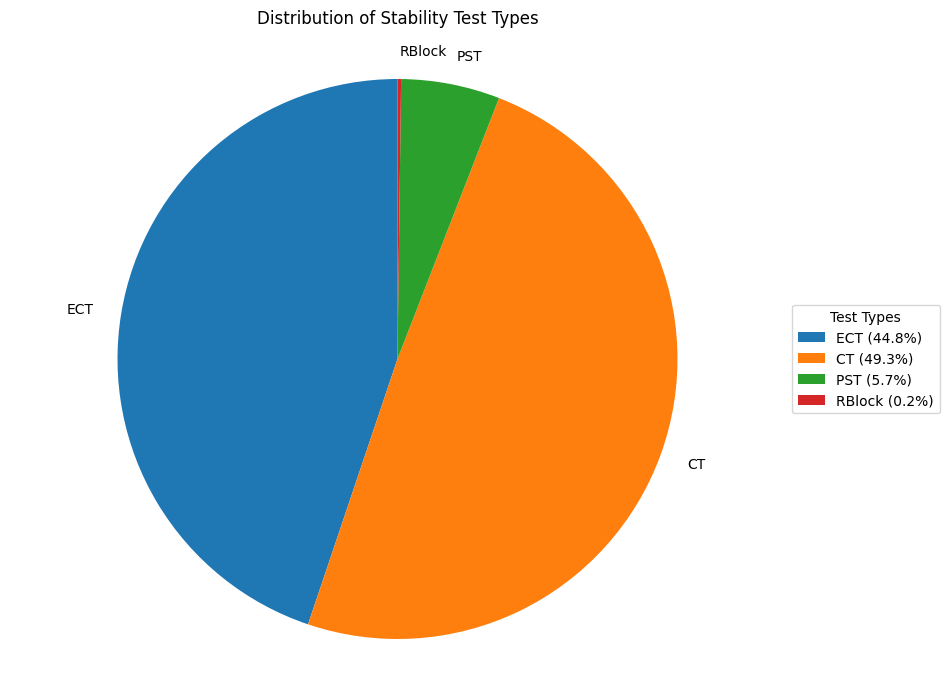

In [14]:
# Calculate total number of each test type and reorder to put RBlock last
test_counts = {
    "ECT": stability_tests_df["Num ECT"].sum(),
    "CT": stability_tests_df["Num CT"].sum(),
    "PST": stability_tests_df["Num PST"].sum(),
    "RBlock": stability_tests_df["Num RBlock"].sum(),
}
# Calculate percentages
total_tests = sum(test_counts.values())
percentages = {k: (v / total_tests) * 100 for k, v in test_counts.items()}

# Create simple labels for pie chart
pie_labels = list(test_counts.keys())

# Create detailed labels with percentages for legend
legend_labels = [f"{k} ({v:.1f}%)" for k, v in percentages.items()]

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(test_counts.values(), labels=pie_labels, startangle=90)
plt.title(
    "Distribution of Stability Test Types", pad=20
)  # Added padding to move title up
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle

# Add a legend
plt.legend(
    legend_labels, title="Test Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.show()

### Example Analysis

#### How often is a Q1 fracture associated with an ECTP on the same layer?

In [15]:
# Get Data

CT_ECT_list = []

for pit in all_pits:
    # If the pit has CT and ECT results
    if len(pit.stability_tests.CT) > 0 and len(pit.stability_tests.ECT) > 0:
        ECTs = pit.stability_tests.ECT  # Get ECT results
        CTs = pit.stability_tests.CT  # Get CT results

        for ect in ECTs:
            for ct in CTs:  # For Every combination of ECT and CT results
                if (
                    ect.depth_top == ct.depth_top and ect.propagation is True
                ):  # If failure on the same level and ECT has propogation
                    results_dict = {
                        "PitID": pit.core_info.pit_id,
                        "ECT Score": ect.test_score,
                        "CT Shear Qual": ct.fracture_character,
                    }
                    CT_ECT_list.append(results_dict)

CT_ECT_df = pd.DataFrame(CT_ECT_list)
# grouped = df.groupby("PitID")
# print(grouped.sum())

# df = df.drop_duplicates(
#    subset=["PitID"], keep="first"
# )  # Drop duplicates per pit NOTE This keeps the first occurance, update?

print(len(CT_ECT_df))

3565


In [16]:
# Map Fracture Character to Shear Quality

fracture_to_shear_qual = {
    "Q1": "Q1",
    "Q2": "Q2",
    "Q3": "Q3",
    "SC": "Q1",
    "SP": "Q1",
    "RP": "Q2",
    "BRK": "Q3",
    "PC": "Q2",
}

# Add the new column using the mapping
CT_ECT_df["Shear Qual"] = CT_ECT_df["CT Shear Qual"].map(fracture_to_shear_qual)

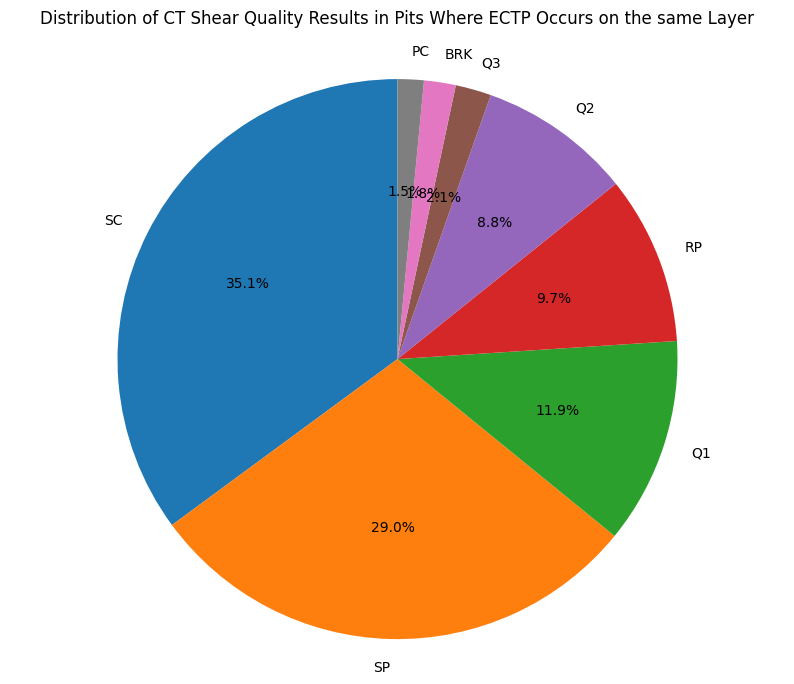

In [17]:
# Create Pie Chart

# Calculate value counts for ShearQual
shear_counts = CT_ECT_df["CT Shear Qual"].value_counts()

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    shear_counts.values,
    labels=shear_counts.index,
    autopct="%1.1f%%",  # Show percentages with 1 decimal place
    startangle=90,
)  # Rotate start of pie to 90 degrees

# Add title
plt.title(
    "Distribution of CT Shear Quality Results in Pits Where ECTP Occurs on the same Layer",
    pad=20,
)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis("equal")

# Show the plot
plt.show()

Treemap grouped by Mapped Shear Quality

In [18]:
# Drop any rows with missing values
CT_ECT_df_clean = CT_ECT_df.dropna(subset=["CT Shear Qual", "Shear Qual"])

# Create the treemap
fig = px.treemap(
    CT_ECT_df_clean,
    path=["Shear Qual", "CT Shear Qual"],
    title="Distribution of CT Shear Quality Results",
    width=1000,
    height=800,
)

# Update layout for better readability
fig.update_layout(
    font_size=14,
    title_font_size=16,
    title_x=0.5,  # Center the title
)

# Show the plot
fig.show()

#### Grain Type by Hand Hardness

In [19]:
layer_info_list = []

for pit in all_pits:
    for layer in pit.snow_profile.layers:
        # Get the grain form name safely, defaulting to None if grainFormPrimary is None
        grain_form_name = (
            layer.grain_form_primary.basic_grain_class_name
            if layer.grain_form_primary
            else None
        )

        layer_info = {
            "Thickness": layer.thickness,
            "Hand Hardness": layer.hardness,
            "Layer of Concern": layer.layer_of_concern,
            "Primary Grain Form Name": grain_form_name,
        }
        layer_info_list.append(layer_info)

layer_info_df = pd.DataFrame(layer_info_list)

print(layer_info_df.head())

    Thickness Hand Hardness Layer of Concern  \
0  [10.0, cm]             F             None   
1  [17.0, cm]            F+             None   
2  [29.0, cm]          None             None   
3   [8.0, cm]             P             None   
4   [8.6, cm]            4F             None   

                             Primary Grain Form Name  
0                            Precipitation particles  
1  Decomposing and fragmented precipitation parti...  
2                                     Rounded grains  
3                                         Melt forms  
4                                         Melt forms  


In [20]:
# Define the order of Hand Hardness levels
hardness_order = [
    "F-",
    "F",
    "F+",
    "-4F",
    "4F",
    "4F+",
    "1F-",
    "1F",
    "1F+",
    "P-",
    "P",
    "P+",
    "K-",
    "K",
    "K+",
    "I-",
    "I",
    "I+",
]

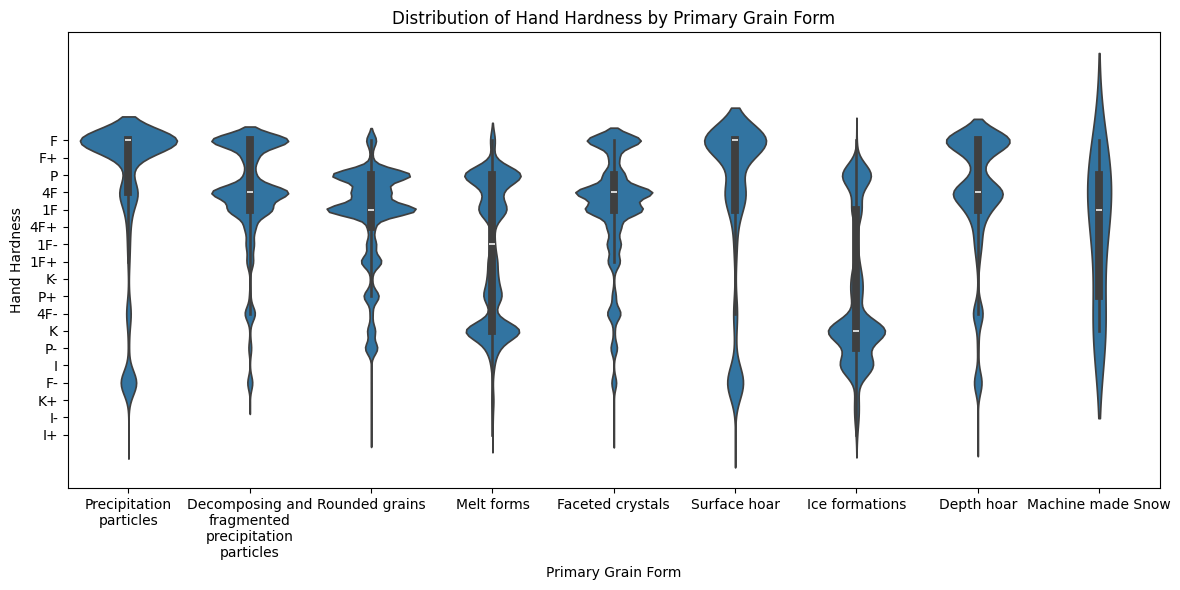

In [21]:
# Create Violin Plot

# Function to wrap text
def wrap_labels(ax, width=20):
    ticks = ax.get_xticks()
    labels = [
        textwrap.fill(label.get_text(), width=width) for label in ax.get_xticklabels()
    ]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)


# Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="Primary Grain Form Name", y="Hand Hardness", data=layer_info_df)
plt.title("Distribution of Hand Hardness by Primary Grain Form")
plt.xlabel("Primary Grain Form")
plt.ylabel("Hand Hardness")
wrap_labels(plt.gca(), width=20)
plt.tight_layout()
plt.show()

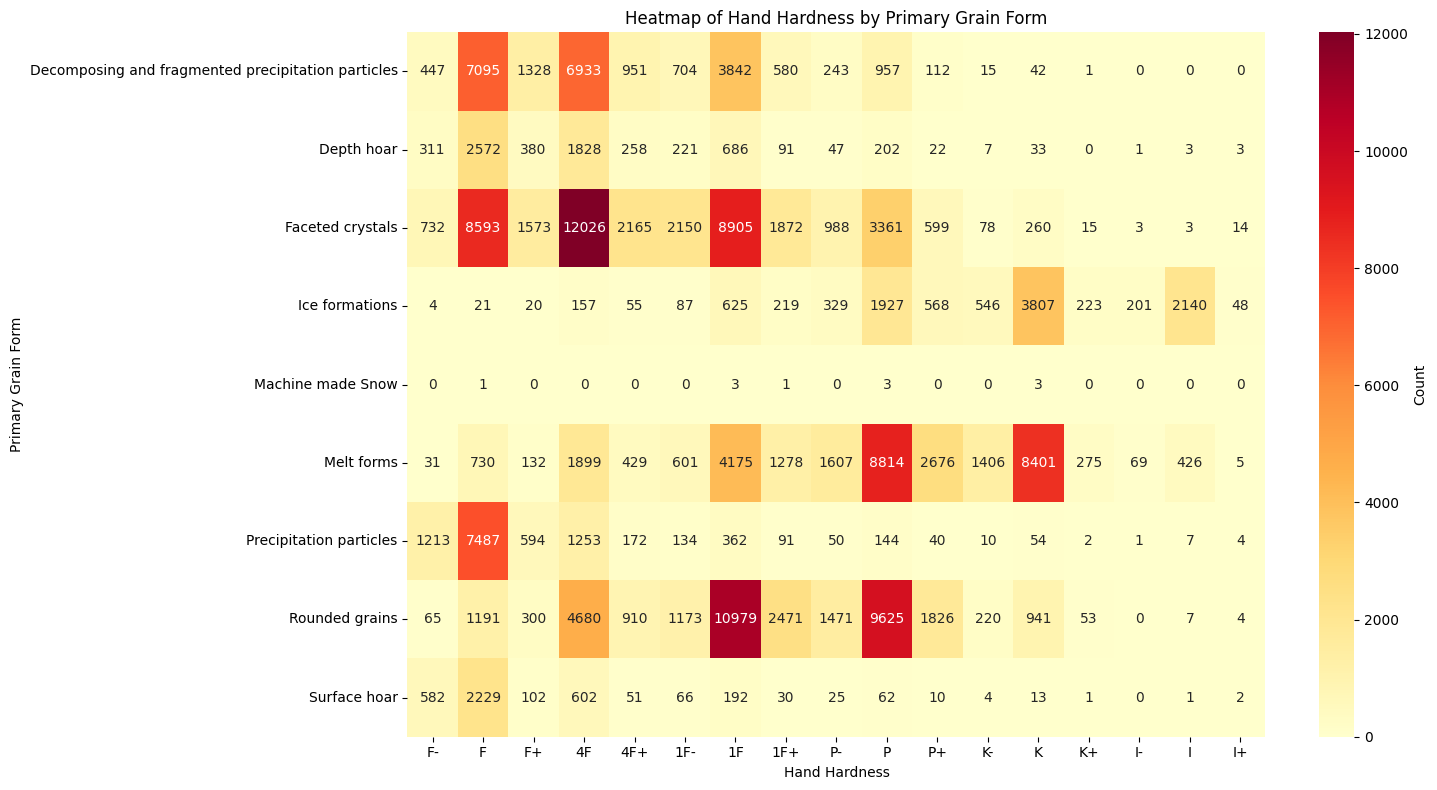

In [22]:
# Cross-tabulation of Hand Hardness and Primary Grain Form Name
heatmap_data = pd.crosstab(
    layer_info_df["Primary Grain Form Name"], layer_info_df["Hand Hardness"]
)

# Reorder the columns according to the specified order
# Only include columns that exist in the data
existing_columns = [col for col in hardness_order if col in heatmap_data.columns]
heatmap_data = heatmap_data[existing_columns]

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(
    heatmap_data,
    annot=True,  # Show numbers in cells
    fmt="d",  # Format as integers
    cmap="YlOrRd",  # Yellow to Orange to Red color scheme
    cbar_kws={"label": "Count"},
)

plt.title("Heatmap of Hand Hardness by Primary Grain Form")
plt.xlabel("Hand Hardness")
plt.ylabel("Primary Grain Form")
plt.tight_layout()
plt.show()

In [23]:
# Map Hardness to group

hardness_to_group = {
    "F-": "F",
    "F": "F",
    "F+": "F",
    "-4F": "4F",
    "4F": "4F",
    "4F+": "4F",
    "1F-": "1F",
    "1F": "1F",
    "1F+": "1F",
    "P-": "P",
    "P": "P",
    "P+": "P",
    "K-": "K",
    "K": "K",
    "K+": "K",
    "I-": "I",
    "I": "I",
    "I+": "I",
}

# Add the new column using the mapping
layer_info_df["Hardness Group"] = layer_info_df["Hand Hardness"].map(hardness_to_group)

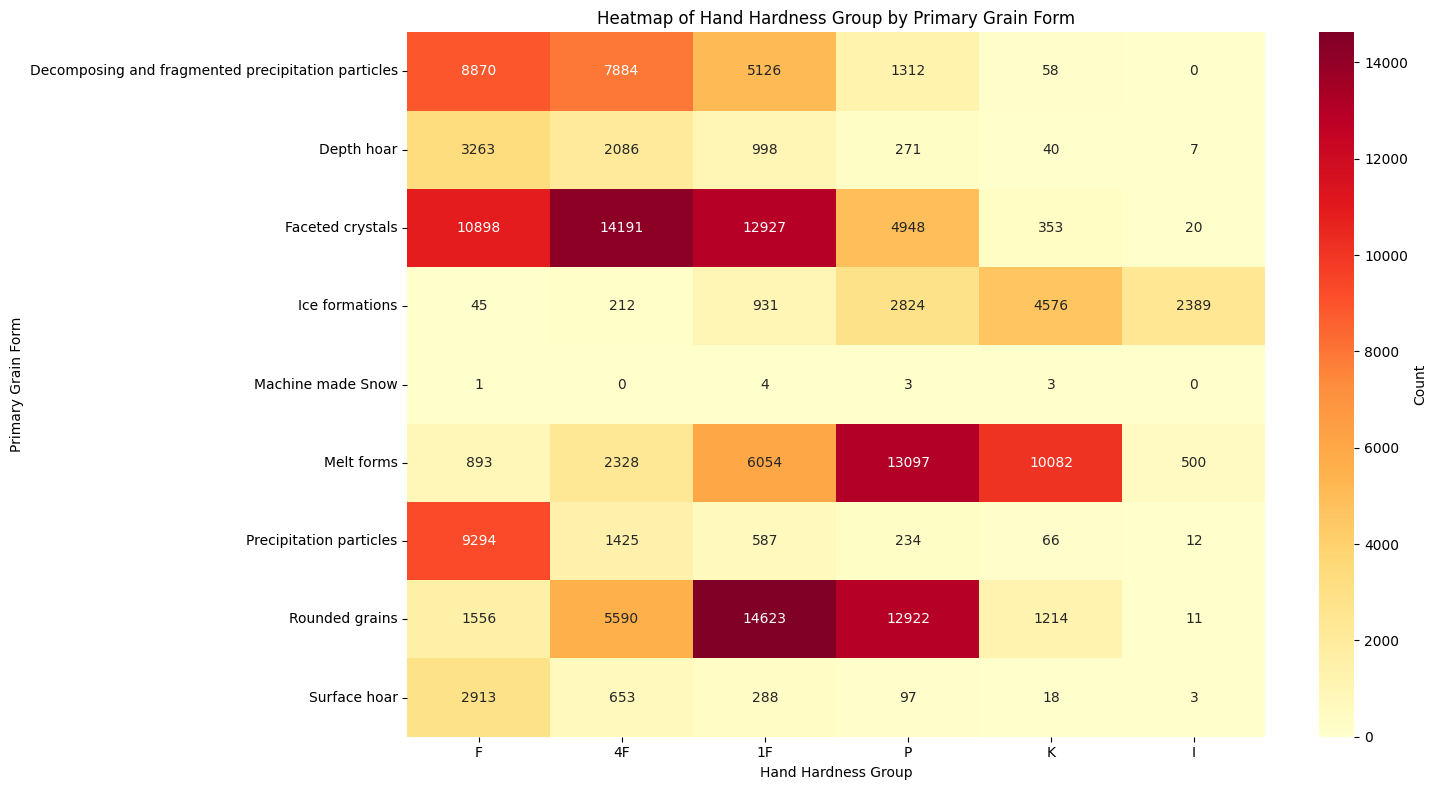

In [24]:
# Cross-tabulation of Hand Hardness Group and Primary Grain Form Name
heatmap_data = pd.crosstab(
    layer_info_df["Primary Grain Form Name"], layer_info_df["Hardness Group"]
)

# Reorder the columns according to the specified order
# Only include columns that exist in the data
existing_columns = [col for col in hardness_order if col in heatmap_data.columns]
heatmap_data = heatmap_data[existing_columns]

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(
    heatmap_data,
    annot=True,  # Show numbers in cells
    fmt="d",  # Format as integers
    cmap="YlOrRd",  # Yellow to Orange to Red color scheme
    cbar_kws={"label": "Count"},
)

plt.title("Heatmap of Hand Hardness Group by Primary Grain Form")
plt.xlabel("Hand Hardness Group")
plt.ylabel("Primary Grain Form")
plt.tight_layout()
plt.show()

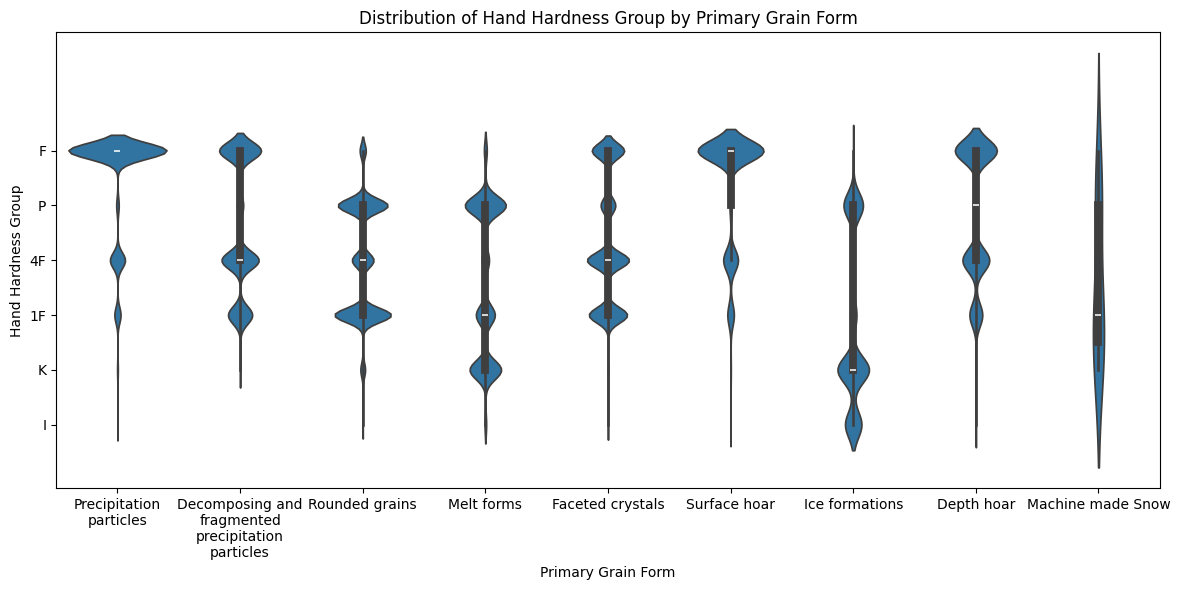

In [25]:
# Create Violin Plot

# Function to wrap text
def wrap_labels(ax, width=20):
    ticks = ax.get_xticks()
    labels = [
        textwrap.fill(label.get_text(), width=width) for label in ax.get_xticklabels()
    ]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)


# Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="Primary Grain Form Name", y="Hardness Group", data=layer_info_df)
plt.title("Distribution of Hand Hardness Group by Primary Grain Form")
plt.xlabel("Primary Grain Form")
plt.ylabel("Hand Hardness Group")
wrap_labels(plt.gca(), width=20)
plt.tight_layout()
plt.show()